## Prepare
##### Terms

- $J_i$: job $i$
- $P_l^i$: operation $l$ of job $i$
- $G_g^i$: operation group $g$ of job $i$
- $M_k$: machine $k$
- $MG_g^i$: set of machines indices that $G_g^i$ might use

##### Decision Variables

- $X_{ilj}^{k}$ := $P_l^i$ (operation $l$ of job $i$) is on the order-position $j$ on $M_k$
- $h_j^k$ := starting time of order-position $j$ on $M_k$
- $s_j^k$ := time elapsed between order-position $j$ and $j+1$ on $M_k$
- $s_0^k$ := idle time from start to first order-position on $M_k$
- $n(k)$ := max number of order-positions $M_k$ can possibly process
- $N(k)$ := job & operation pair $(i, l)$, or $(J_i, P_l^i)$, that can possibly use $M_k$
- $TX_j^k$ := process time of the $j$-th order-position task on $M_k$

##### Known Variables

- $t_{il}^{k}$ := time needed for $P_l^i$ (operation $l$ of job $i$) on using $M_k$
- $c_{il}^{S}$ := total numbers of time $P_l^i$ will use any machine $M_k \in S$ 

In [237]:
using Statistics

## Objective

\begin{align*}
\min \quad h ^ *
\end{align*}

## Constraint

##### Constraint Set 1: each job & operation is completed by its required machine(s)

\begin{align*}
&   \quad \sum_{k \in S} \sum_{j=1}^{n(k)} X_{ilj}^k = c_{il}^{S}, \ \forall (i, l)\\
\end{align*}

##### Constraint Set 2: each machine's each order-position can have at most 1 job a time

\begin{align*}
&   \quad \sum_{(i, l) \in N(k)} X_{ilj}^k \leq 1, \ \forall j \in [n(k)], \ \forall k \in M\\
\end{align*}

##### Constraint Set 3: define time variables (for ordering constraints) 

\begin{align*}
&   \quad TX_j^k = \sum_{(i, l) \in N(k)} t_{il}^k X_{ilj}^k, \ \forall j \in [n(k)], \ \forall k \in M\\
\end{align*}

\begin{align*}
&   \quad h_1^k = s_0^k, \ \forall k \in M\\
&   \quad h_j^k = \sum_{q = 1}^{j-1} TX_{q}^k + \sum_{q = 0}^{j-1} S_{q}^k, \ \forall j \in 2 \cdots n(k), \ \forall k \in M\\
\end{align*}

##### Constraint Set 4: for each job, each group must be complete in the given group order

\begin{align*}
&   \quad h_{j'}^a + t_{il'}^a X_{il'j'}^a \leq h_{j''}^b + M(1-X_{il'j'}^a) + M(1-X_{il''j''}^b) \\
&   \quad \quad \quad \forall a \in MG_g^i, \forall b \in MG_{g+1}^i, \forall P_{l'}^i \in G_g^i, \forall P_{l''}^i \in G_{g+1}^i, 
\forall j' \in [n(a)], \forall j'' \in [n(b)], \forall G_g^i \in i, \forall i
\end{align*}

##### Constraint Set 5: for each job, within each group, order doesn't matter, but must only take one machine per time

\begin{align*}
&   \quad h_{j'}^a + t_{il'}^a X_{il'j'}^a \leq h_{j''}^b + M(1-X_{il'j'}^a) + M(1-X_{il''j''}^b) + \delta M \\
&   \quad h_{j''}^a + t_{il''}^a X_{il''j''}^a \leq h_{j'}^b + M(1-X_{il'j'}^a) + M(1-X_{il''j''}^b) + (1 - \delta) M \\
&   \quad \quad \quad 
\forall (a, b) \in MG_g^i, \forall (P_{l'}^i, P_{l''}^i) \in G_g^i, 
\forall j' \in [n(a)], \forall j'' \in [n(b)], \forall G_g^i \in i, \forall i
\end{align*}

##### Constraint Set 6: define make span

\begin{align*}
&   \quad h ^ * \geq h_{n(k)}^k + TX_{n(k)}^k, \ \forall k \in M\\
\end{align*}

In [255]:
# Define your sets based on the problem
# Replace these with actual numbers
II = 3 # Number of jobs
LL = Dict(1 => [4], 2 => [5], 3 => [2]) # Number of operations for each job
MM = 6 # Number of machines
# from all (i, g) job-i group-g to machines that this group might use
MG = Dict(
    (1, 1) => [1], (1, 2) => [2, 3], (1, 3) => [5, 6],
    (2, 1) => [1], (2, 2) => [2, 3], (2, 3) => [4], (2, 4) => [5, 6],
    (3, 1) => [1], (3, 2) => [6]
) 
# group count for each job
GCJ = Dict(1 => 3, 2 => 4, 3 => 2)
# max number of order-positions machine-k can possibly process
nk = Dict(1 => 3, 2 => 2, 3 => 2, 4 => 1, 5 => 2, 6 => 3)
# set of (i) job-i that can possibly use machine-k
Nk = Dict(
    1 => [1, 2, 3], 
    2 => [1, 2], 
    3 => [1, 2],
    4 => [2], 
    5 => [1, 2], 
    6 => [1, 2, 3]
)
# time needed for job-i to use machine-k
TIK = Dict(
    (1, 1) => 60, 
    (1, 2) => 30,
    (1, 3) => 60,
    (1, 5) => 20,
    (1, 6) => 10,
    (2, 1) => 60, 
    (2, 2) => 30,
    (2, 3) => 60,
    (2, 4) => 20,
    (2, 5) => 40,
    (2, 6) => 20,
    (3, 1) => 60, 
    (3, 6) => 125,
)
# job's possible machine set
JobMachine = Dict(1 => [1, 2, 3, 5, 6], 2 => [1, 2, 3, 4, 5, 6], 3 => [1, 6])
JobMachine1 = Dict(1 => [1, 2, 3], 2 => [1, 2, 3, 4], 3 => [1, 6])
JobMachine2 = Dict(1 => [5, 6], 2 => [5, 6], 3 => [])

# job-i operation-l pairs
JO = [(1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2)];

In [265]:
using Gurobi, JuMP
model = Model(Gurobi.Optimizer)

# Decision Variables - Sparse definition using a dictionary
validx = [ (i, j, k) for i in 1:II for k in JobMachine[i] for j in 1:nk[k] ]
@variable(model, x[validx], Bin)
@variable(model, h[[ (j, k) for k in 1:MM for j in 1:nk[k] ]] >= 0)
@variable(model, s[[ (j, k) for k in 1:MM for j in 1:nk[k] ]] >= 0)
@variable(model, s0[ k in 1:MM ] >= 0)
@variable(model, TX[[ (j, k) for k in 1:MM for j in 1:nk[k] ]] >= 0)
valid_deltas = []
for (group, machines) in MG
    for a in 1:length(machines)
        for b in (a+1):length(machines)  # Ensure b > a to get unique pairs without repetition
            for jj in 1:nk[machines[a]], jjj in 1:nk[machines[b]]
                push!( valid_deltas, (group[1], group[2], machines[a], machines[b], jj, jjj) )
            end
        end
    end
end
@variable(model, delta[ valid_deltas ] >= 0);
@variable(model, h_star >= 0);

# Objective: Minimize the maximum completion time
@objective(model, Min, h_star);

# Constraint Set 1: Each job is processed a specific number of times
for i in 1:II
    for k in JobMachine1[i]
        @constraint(model, sum(x[(i, j, k)] for j in 1:nk[k]) == 1)
    if length(JobMachine2[i]) > 0
        k1 = JobMachine2[i][1]
        k2 = JobMachine2[i][2]
        @constraint(model, sum(x[(i, j, k1)] for j in 1:nk[k1]) + sum(x[(i, j, k2)] for j in 1:nk[k2]) == 1)
        end
    end
end
# Constraint Set 2: At most one operation at each order position on each machine
for k in 1:MM 
    for j in 1:nk[k]
        @constraint(model, sum(x[(i, j, k)] for i in Nk[k]) <= 1)
    end
end
# Constraint Set 3: Define the processing time for each order position on each machine
for k in 1:MM
    for j in 1:nk[k]
        @constraint(model, TX[(j, k)] == sum( get(TIK, (i, k), 0) * x[(i, j, k)] for i in Nk[k] ))
    end
end
for k in 1:MM
    @constraint(model, h[(1, k)] == s0[k])
end
for k in 1:MM
    for j in 2:nk[k]
        @constraint(model, h[(j, k)] == sum( TX[(q, k)] for q in 1:j-1 ) + sum( s[(q, k)] for q in 1:j-1 ) + s0[k])
    end
end
# Constraint Set 4: Precedence constraints
M = 200
for i in 1:II
    for g1 in 2:GCJ[i]
        g = g1 - 1
        # g and g1 are group id of job i: g & g+1
        for a in MG[(i, g)]
            for b in MG[(i, g1)]
                for jj in 1:nk[a]
                    for jjj in 1:nk[b]
                        @constraint(
                            model, 
                            h[(jj, a)] + get(TIK, (jj, a), 0) * x[(i, jj, a)] <= h[(jjj, b)] + M * (1 - x[(i, jj, a)]) + M * (1 - x[(i, jjj, b)])
                        )
                    end
                end
            end
        end
    end
end
# Constraint Set 5: No overlap within the same machine group
for (group, machines) in MG
    for a in 1:length(machines)
        for b in (a+1):length(machines)  # Ensure b > a to get unique pairs without repetition
            for jj in 1:nk[machines[a]]
                for jjj in 1:nk[machines[b]]
                    i = group[1]
                    ma = machines[a]
                    mb = machines[b]
                    @constraint(
                        model, 
                        h[(jj, ma)] + get(TIK, (jj, ma), 0) * x[(i, jj, ma)] <= h[(jjj, mb)] + M * (1 - x[(i, jj, ma)]) + M * (1 - x[(i, jjj, mb)]) 
                        + M * delta[(i, group[2], ma, mb, jj, jjj)]
                    )
                    @constraint(
                        model, 
                        h[(jjj, mb)] + get(TIK, (jjj, mb), 0) * x[(i, jjj, mb)] <= h[(jj, ma)] + M * (1 - x[(i, jj, ma)]) + M * (1 - x[(i, jjj, mb)]) 
                        + M * (1 - delta[(i, group[2], ma, mb, jj, jjj)])
                    )
                end
            end
        end
    end
end
# Constraint Set 6: h_star is greater than or equal to the end time of the last operation on each machine
for k in 1:MM
    @constraint(model, h_star >= h[(nk[k], k)] + TX[(nk[k], k)])
end

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22


In [266]:
optimize!(model)

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 163 rows, 97 columns and 641 nonzeros
Model fingerprint: 0xab0f2b38
Variable types: 66 continuous, 31 integer (31 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+02]
Presolve removed 57 rows and 59 columns
Presolve time: 0.00s
Presolved: 106 rows, 38 columns, 395 nonzeros
Variable types: 7 continuous, 31 integer (25 binary)
Found heuristic solution: objective 335.0000000
Found heuristic solution: objective 320.0000000
Found heuristic solution: objective 260.0000000
Found heuristic solution: objective 250.0000000

Root relaxation: objective 1.800000e+02, 48 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl | 

In [267]:
x_result = Dict()
for idx in [ (i, j, k) for i in 1:II for k in JobMachine[i] for j in 1:nk[k] ]
    x_result[idx] = value.(x[idx])
end
h_result = Dict()
for idx in [ (j, k) for k in 1:MM for j in 1:nk[k] ]
    h_result[idx] = value.(h[idx])
end
s_result = Dict()
for idx in [ (j, k) for k in 1:MM for j in 1:nk[k] ]
    s_result[idx] = value.(s[idx])
end
s0_result = Dict()
for idx in 1:MM
    s0_result[idx] = value.(s0[idx])
end
TX_result = Dict()
for idx in [ (j, k) for k in 1:MM for j in 1:nk[k] ]
    TX_result[idx] = value.(TX[idx])
end

In [268]:
h_result

Dict{Any, Any} with 13 entries:
  (1, 2) => 120.0
  (3, 1) => 120.0
  (2, 5) => 40.0
  (1, 3) => 120.0
  (1, 4) => 180.0
  (2, 6) => 185.0
  (2, 1) => 60.0
  (1, 5) => 40.0
  (2, 2) => 180.0
  (1, 6) => 60.0
  (2, 3) => 180.0
  (1, 1) => 0.0
  (3, 6) => 240.0

In [269]:
# group_info = Dict(
#     (1, 1) => 1, (1, 2) => 2, (1, 3) => 2, (1, 5) => 3, (1, 6) => 3,
#     (2, 1) => 1, (2, 2) => 2, (2, 3) => 2, (2, 4) => 3, (2, 5) => 4, (2, 6) => 4,
#     (3, 1) => 1, (3, 6) => 2
# )

In [270]:
# using Plots

# # Adjusted function to plot Gantt chart with job legends and group annotations
# function plot_gantt_chart_with_annotations(h_result, TX_result, nk, MM, num_jobs, group_info)
#     gantt_chart = plot(title="Job Schedule Gantt Chart by Machine", legend=:outertopright)

#     # Generate a color for each job
#     job_colors = distinguishable_colors(num_jobs)

#     plotted_jobs = Dict{Int, Bool}()
#     # Plot each task and annotate with the group information
#     for k in 1:MM
#         machine_schedule = [(h_result[(j, k)], end_times[(j, k)], j) for j in 1:get(nk, k, 0)]
#         for (start, finish, job_id) in machine_schedule
#             color = job_colors[job_id]
#             label = haskey(plotted_jobs, job_id) ? "" : "Job $job_id"  # Only label the first task of each job
#             plotted_jobs[job_id] = true
#             plot!([start, finish], [k, k], line=(10, color), label=label)
#             # Annotate each bar with the group information
#             # 'group_info' should be a dictionary or an array that maps (job_id, k) to the group it belongs to
#             group_label = group_info[(job_id, k)]
#             annotate!([(mean([start, finish]), k, text(group_label, 8, :center))])
#         end
#     end

#     xlabel!("Time")
#     ylabel!("Machine")
#     return gantt_chart
# end

# # Define h_result, TX_result, nk, MM, num_jobs, and group_info with actual values from your model

# # Now let's create and display the Gantt chart with job legends and group annotations
# gantt_chart_with_annotations = plot_gantt_chart_with_annotations(h_result, TX_result, nk, MM, II, group_info)
# display(gantt_chart_with_annotations)

In [271]:
TX_result

Dict{Any, Any} with 13 entries:
  (1, 2) => 30.0
  (3, 1) => 60.0
  (2, 5) => 0.0
  (1, 3) => 60.0
  (1, 4) => 20.0
  (2, 6) => 20.0
  (2, 1) => 60.0
  (1, 5) => 0.0
  (2, 2) => 30.0
  (1, 6) => 125.0
  (2, 3) => 60.0
  (1, 1) => 60.0
  (3, 6) => 10.0

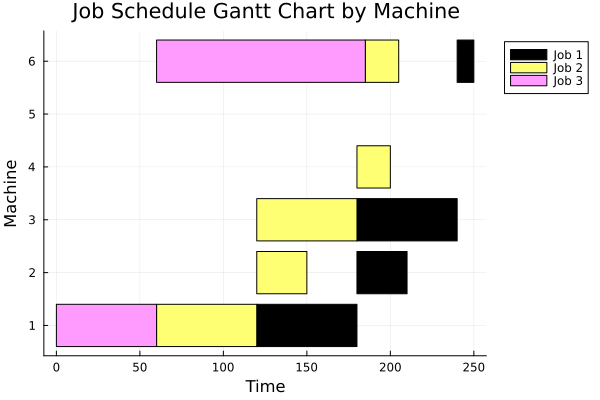

In [272]:
# Function to plot Gantt chart with job legends
function plot_gantt_chart_with_job_legends(h_result, TX_result, x_result, nk, MM, num_jobs)
    end_times = Dict()
    for (j, k) in keys(TX_result)
        end_times[(j, k)] = h_result[(j, k)] + TX_result[(j, k)]
    end
    
    gantt_chart = plot(title="Job Schedule Gantt Chart by Machine", legend=:outertopright)

    # Generate a color for each job
    job_colors = distinguishable_colors(num_jobs)

    # Dictionary to keep track of which jobs have been plotted (to avoid duplicate legend entries)
    plotted_jobs = Dict()
    
    # Plot each task
    for k in 1:MM
        machine_schedule = []
        # Gather the tasks for this machine
        for i in 1:II
            for j in 1:nk[k]
                if get(x_result, (i, j, k), 0) > 0.1
                    push!(machine_schedule, (h_result[(j, k)], h_result[(j, k)] + TX_result[(j, k)], i))
                    break
                end
            end
        end
        for (start, finish, job_id) in machine_schedule
            color = job_colors[job_id]
            label = haskey(plotted_jobs, job_id) ? "" : "Job $job_id"  # Only label the first task of each job
            plotted_jobs[job_id] = true
            # plot!([start, finish], [k, k], bar=(150, color), label=label)
            shape = Shape([start, start, finish, finish], 
                      [k - 0.4, k + 0.4, k + 0.4, k - 0.4])
            plot!(shape, color=color, label=label)
        end
    end

    xlabel!("Time")
    ylabel!("Machine")
    return gantt_chart
end

# Assuming the model has been optimized and we have the results
# Calculate the end times for the tasks and populate h_result and TX_result accordingly

# Now let's create and display the Gantt chart with job legends
gantt_chart_with_job_legends = plot_gantt_chart_with_job_legends(h_result, TX_result, x_result, nk, MM, II)
display(gantt_chart_with_job_legends)

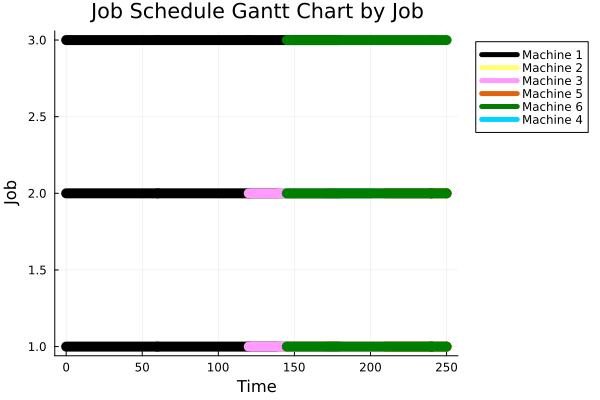

In [209]:
using Plots

# Function to plot Gantt chart from a job's perspective with machines in the legend
function plot_gantt_chart_by_job(h_result, TX_result, validx, nk, num_jobs, MM)
    # Initialize the plot
    gantt_chart = plot(title="Job Schedule Gantt Chart by Job", legend=:outertopright)

    # Generate a color for each machine
    machine_colors = distinguishable_colors(MM)
    
    # Dictionary to keep track of which machines have been plotted (to avoid duplicate legend entries)
    plotted_machines = Dict()

    # Plot each task
    for (job_id, operation_id, machine_id) in validx
        start_time = value(h_result[(operation_id, machine_id)])
        duration = value(TX_result[(operation_id, machine_id)])
        color = machine_colors[machine_id]
        label = haskey(plotted_machines, machine_id) ? "" : "Machine $machine_id"  # Only label the first task of each machine
        plotted_machines[machine_id] = true
        
        # Plot the task with a horizontal bar
        plot!([start_time, start_time + duration], [job_id, job_id], line=(10, color), label=label)
    end

    xlabel!("Time")
    ylabel!("Job")
    return gantt_chart
end

# Assuming the model has been optimized and we have the results
# Define `h_result`, `TX_result`, `validx`, `nk`, `num_jobs`, and `MM` with the actual data

# Call the function and pass the necessary variables
gantt_chart_by_job = plot_gantt_chart_by_job(h_result, TX_result, validx, nk, II, MM)

# Display the Gantt chart
display(gantt_chart_by_job)

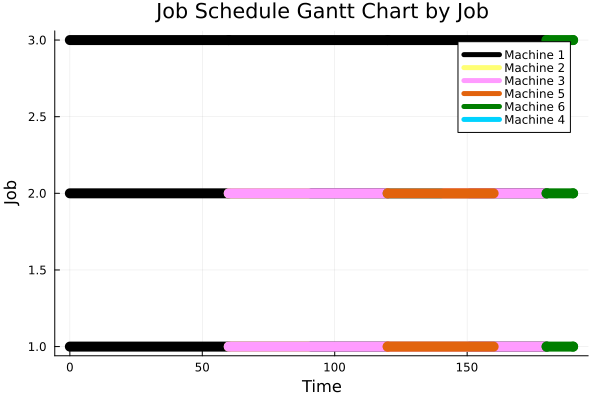

In [141]:
using Plots

# Adjust the function to correctly plot the Gantt chart by job
function plot_gantt_chart_by_job(h, TX, validx, num_jobs, num_machines)
    gantt_chart = plot(title="Job Schedule Gantt Chart by Job", legend=:topright)

    # Create a color palette for the machines
    machine_colors = distinguishable_colors(num_machines)

    # Initialize a dictionary to store legend labels to ensure each machine label is added only once
    labels = Dict((k => "Machine $k") for k in 1:num_machines)

    # Plot each task
    for (job_id, operation_id, machine_id) in validx
        start_time = value(h[(operation_id, machine_id)])
        end_time = start_time + value(TX[(operation_id, machine_id)])
        label = labels[machine_id] # Get the label for this machine
        labels[machine_id] = ""    # Clear the label so it's only used once

        plot!([start_time, end_time], [job_id, job_id], line=(10, machine_colors[machine_id]), label=label)
    end

    xlabel!("Time")
    ylabel!("Job")
    return gantt_chart
end

# Assuming the model has been optimized and we have the results
# Define `h`, `TX`, `validx`, `II`, and `MM` with the actual data

# Call the function and pass the necessary variables
gantt_chart_by_job = plot_gantt_chart_by_job(h, TX, validx, II, MM)

# Display the Gantt chart
display(gantt_chart_by_job)


In [196]:
for (key, v) in x_result # i k j
    if key[1] == 2
        println(key, v)
    end
end

(2, 2, 6)-0.0
(2, 3, 6)-0.0
(2, 1, 4)1.0
(2, 1, 1)1.0
(2, 1, 5)1.0
(2, 1, 3)1.0
(2, 2, 1)-0.0
(2, 2, 5)-0.0
(2, 3, 1)-0.0
(2, 2, 3)0.0
(2, 1, 2)1.0
(2, 2, 2)0.0
(2, 1, 6)-0.0


In [128]:
h_result[(3, 1)]

120.0

In [172]:
TX_result[(1, 6)]

0.0

In [175]:
for k in 1:MM
    for j in 1:nk[k]
        println(j, ' ', k)
        println(TX_result[(j, k)], ' ', sum( get(TIK, (i, k), 0) * x_result[(i, j, k)] for i in Nk[k] ))
    end
end

1 1
60.0 60.0
2 1
60.0 60.0
3 1
60.0 60.0
1 2
30.0 30.0
2 2
30.0 30.0
1 3
60.0 60.0
2 3
60.0 60.0
1 4
20.0 20.0
1 5
0.0 0.0
2 5
40.0 40.0
1 6
0.0 0.0
2 6
10.0 10.0
3 6
0.0 0.0


In [178]:
k = 6
j = 1
for i in Nk[k]
    println(i, ' ', TIK[(i, k)], ' ', x_result[(i, j, k)], ' ')
end

1 10 0.0 
2 20 0.0 


LoadError: KeyError: key (3, 6) not found

In [ ]:
get(TIK, (i, k), 0)